In [123]:
import torch
from torch import nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

def cub_transform(image_size=448):
    """Define transformations for training and validation datasets."""
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    val_transform = transforms.Compose([
        transforms.Resize(int(image_size / 0.875)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    return train_transform, val_transform

path_to_pth = 'cub_pytorch_resnet50.pth'

model = models.resnet50(pretrained=False)

model.load_state_dict(torch.load(path_to_pth))


train_transform, val_transform = cub_transform()


train_dataset_path = '/Users/arslanmalik/Documents/MS Project/CUB_200_2011/CUB_200_2011/images'
train_dataset = ImageFolder(root=train_dataset_path, transform=train_transform)


In [124]:
class ResNetCAM(nn.Module):
    def __init__(self):
        super(ResNetCAM, self).__init__()
        
        original_model = models.resnet50(pretrained=False)
        

        self.features = nn.Sequential(

            *list(original_model.children())[:-2]
        )
    
    def forward(self, x):
        x = self.features(x)
        return x


model_cam = ResNetCAM()
state_dict = torch.load('cub_pytorch_resnet50.pth')

state_dict = {k: v for k, v in state_dict.items() if not k.startswith('fc')}
model_cam.load_state_dict(state_dict, strict=False)


_IncompatibleKeys(missing_keys=['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.4.0.conv1.weight', 'features.4.0.bn1.weight', 'features.4.0.bn1.bias', 'features.4.0.bn1.running_mean', 'features.4.0.bn1.running_var', 'features.4.0.conv2.weight', 'features.4.0.bn2.weight', 'features.4.0.bn2.bias', 'features.4.0.bn2.running_mean', 'features.4.0.bn2.running_var', 'features.4.0.conv3.weight', 'features.4.0.bn3.weight', 'features.4.0.bn3.bias', 'features.4.0.bn3.running_mean', 'features.4.0.bn3.running_var', 'features.4.0.downsample.0.weight', 'features.4.0.downsample.1.weight', 'features.4.0.downsample.1.bias', 'features.4.0.downsample.1.running_mean', 'features.4.0.downsample.1.running_var', 'features.4.1.conv1.weight', 'features.4.1.bn1.weight', 'features.4.1.bn1.bias', 'features.4.1.bn1.running_mean', 'features.4.1.bn1.running_var', 'features.4.1.conv2.weight', 'features.4.1.bn2.weight', 'features.4.1.bn2.bias', 

In [125]:
def get_cam(feature_maps, weight_fc, class_idx):

    _, _, H, W = feature_maps.shape
    cam = torch.zeros((H, W), dtype=torch.float32)

    for i, w in enumerate(weight_fc[class_idx]):
        cam += w * feature_maps[0, i, :, :]

    cam = cam.relu()
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = transforms.functional.resize(cam.unsqueeze(0).unsqueeze(0), (448, 448), interpolation=transforms.InterpolationMode.BILINEAR)
    return cam.squeeze()

# Example usage
feature_maps = model_cam(torch.randn(1, 3, 448, 448))
weight_fc = model.fc.weight.data
cam = get_cam(feature_maps, weight_fc, class_idx=100) 


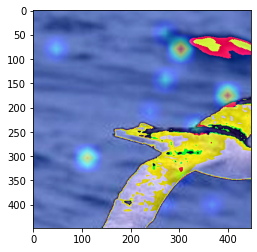

In [126]:
def show_cam_on_image(img, mask):

    heatmap = plt.get_cmap('jet')(mask.detach().numpy())[:, :, :3] 
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float()
    heatmap /= heatmap.max()  # Normalize
    combined = heatmap + img.cpu()
    combined /= combined.max()  # Normalize

    plt.imshow(transforms.ToPILImage()(combined))
    plt.show()

i = 0
while i< len(train_dataset):
    img_tensor, _ = train_dataset[i] 
    show_cam_on_image(img_tensor, cam)
    i+=1
#just for example
# img_tensor, _ = train_dataset[0] 
# show_cam_on_image(img_tensor, cam)

Original image shape: torch.Size([1, 3, 448, 448])
Processed image shape: (448, 448, 3)
Heatmap for superimposition shape: (448, 448, 3)


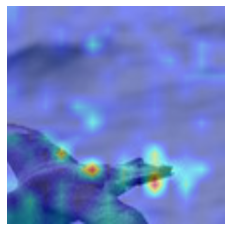

In [127]:
# !pip install opencv-python
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import cv2 

class ResNetGradCAM(ResNetCAM):
    def forward(self, x):
        
        feature_maps = self.features(x)
        self.gradients = []
        h = feature_maps.register_hook(self.save_gradient) 
        pooled_features = F.adaptive_avg_pool2d(feature_maps, 1).view(feature_maps.size(0), -1)
        return feature_maps, pooled_features

    def save_gradient(self, grad):
        self.gradients.append(grad)

def grad_cam(model, x, class_idx):
    feature_maps, output = model(x)
    model.zero_grad()  
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][class_idx] = 1  
    output.backward(gradient=one_hot_output, retain_graph=True)  

    gradients = model.gradients[-1]
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for i in range(feature_maps.size(1)):  
        feature_maps[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(feature_maps, dim=1).squeeze()  
    heatmap = np.maximum(heatmap.detach().numpy(), 0)  
    heatmap /= np.max(heatmap)
    return heatmap



def show_grad_cam_on_image(img, heatmap):
    print("Original image shape:", img.shape) 

    heatmap = cv2.resize(heatmap, (img.shape[3], img.shape[2]))  
    heatmap = np.uint8(255 * heatmap) 
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) 

    img = img.squeeze().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min()) 
    print("Processed image shape:", img.shape) 
    heatmap = heatmap.astype(np.float32) / 255.0
    print("Heatmap for superimposition shape:", heatmap.shape) 
    
    superimposed_img = heatmap * 0.4 + img * 0.6
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

i = 0
while i<len(train_dataset):
    img_tensor, _ = train_dataset[i]  
    img_tensor.unsqueeze_(0) 

    model_grad_cam = ResNetGradCAM()
    state_dict = torch.load('cub_pytorch_resnet50.pth')
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith('fc')}
    model_grad_cam.load_state_dict(state_dict, strict=False)

    heatmap = grad_cam(model_grad_cam, img_tensor, class_idx=100)
    show_grad_cam_on_image(img_tensor, heatmap)
    i+=1

#just for example
# img_tensor, _ = train_dataset[0]  
# img_tensor.unsqueeze_(0) 

# model_grad_cam = ResNetGradCAM()
# state_dict = torch.load('cub_pytorch_resnet50.pth')
# state_dict = {k: v for k, v in state_dict.items() if not k.startswith('fc')}
# model_grad_cam.load_state_dict(state_dict, strict=False)

# heatmap = grad_cam(model_grad_cam, img_tensor, class_idx=100)
# show_grad_cam_on_image(img_tensor, heatmap)